In [1]:
#from stesml.model_tools import build_train_test_model
from stesml.model_tools import get_h_from_T_results
from stesml.model_tools import get_T_from_h_results

from stesml.data_tools import get_scenario_index
from stesml.data_tools import get_cv

from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error

from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_Ac

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

import tensorflow.keras.backend as kb

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

error: Error -5 while decompressing data: incomplete or truncated stream

In [266]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [267]:
def load_data(scenario_index, selected_index):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))
        f_df = pd.read_csv(f, skiprows=[1])
        f_df["Ti"] = Ti
        df_arr.append(f_df)
    combined_df = pd.concat(df_arr)
    return combined_df

In [268]:
def get_train_data(scenario_index, train_index):
    train_df = load_data(scenario_index, train_index)
    X_train = train_df[["flow-time", "Tw", "Ti"]].to_numpy()
    y_train = train_df[['Tavg', 'h', 'Tw', 'cylinder_q_awa']].to_numpy()
    return X_train, y_train

In [269]:
def get_test_data(scenario_index, test_index):
    test_df = load_data(scenario_index, test_index)
    X_test = test_df[["flow-time", "Tw", "Ti"]].to_numpy()
    y_test = test_df[['Tavg', 'h', 'Tw', 'cylinder_q_awa']].to_numpy()
    return X_test, y_test

In [270]:
def get_train_and_test_data(scenario_index, train_index, test_index, scale=False):
    X_train, y_train = get_train_data(scenario_index, train_index)
    X_test, y_test = get_test_data(scenario_index, test_index)
    
    if scale:
        scaler_x = StandardScaler().fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_test = scaler_x.transform(X_test)
        
        scaler_y = StandardScaler().fit(y_train)
        #y_train = scaler_y.transform(y_train)
        #y_test = scaler_y.transform(y_test)
        
        return X_train, y_train, X_test, y_test, scaler_x, scaler_y
    
    return X_train, y_train, X_test, y_test

In [271]:
def build_NN_model(n_layers=3, n_hidden_units=50):
    model = Sequential()
    model.add(Dense(n_hidden_units, activation='relu', input_shape=(3,)))
    for i in range(n_layers-1):
        model.add(Dense(n_hidden_units, activation='relu'))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss=custom_piloss, run_eagerly=True)
    model.build()
    return model

In [272]:
def get_model(model_type, parameters):
    if model_type == "XGBoost":
        # No need to return model for XGBoost
        # Model is instantiated and trained via xgboost.train in the fit_model method below
        model = None
    elif model_type == "RandomForest":
        n_estimators = parameters['n_estimators']
        max_depth = parameters['max_depth']
        max_samples = parameters['max_samples']
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_samples=max_samples, n_jobs=-1)
    elif model_type == "NN":
        n_layers = parameters['n_layers']
        n_hidden_units = parameters['n_hidden_units']
        model = build_NN_model(n_layers, n_hidden_units)
    else:
        print("Please choose either XGBoost, RandomForest, or NN for model type")
        return None
    return model

In [273]:
def fit_model(model, model_type, X_train, y_train, X_test=None, y_test=None, parameters=None):
    if X_test is None: # If no validation data is passed, validate with training data
        X_test = X_train
        y_test = y_train
        eval_name = 'train'
    else:
        eval_name = 'test'
    if model_type == "NN":
        batch_size = parameters['batch_size']
        epochs = parameters['epochs']
        model.fit(x=X_train, 
                  y=y_train,
                  batch_size=batch_size,
                  epochs=epochs, # If training ever reaches 100 epochs without early stopping, this should be increased
                  validation_data=(X_test, y_test),
                  callbacks=[earlystopping_callback])
    elif model_type == "XGBoost":
        parameters['eval_metric'] = 'rmse'
        num_boost_round = parameters['num_boost_round']
        dtrain = xgb.DMatrix(data=X_train,
                             label=y_train)
        dtest = xgb.DMatrix(data=X_test,
                             label=y_test)
        model = xgb.train(params=parameters,
                        dtrain=dtrain,
                        num_boost_round=num_boost_round, # If training ever reaches 10000 rounds without early stopping, this should be increased
                        early_stopping_rounds=20,
                        evals=[(dtest,eval_name)],
                        verbose_eval=20)
    elif model_type == "RandomForest":
        model.fit(X_train, y_train)
    return model

In [274]:
def evaluate_results(metric, y_test, y_hat):
    if metric == 'rmse':
        result = mean_squared_error(y_test, y_hat, squared=False)
    elif metric == 'r2':
        result = r2_score(y_test, y_hat)
    else:
        print('Metric must either be rmse or r2')
        return None
    return result

In [275]:
def get_predictions(model, X_test, y_test=None, scale=False, scaler_y=None, model_type='NN'):
    if model_type == 'XGBoost':
        X_test = xgb.DMatrix(data=X_test)
    y_hat = model.predict(X_test)
    if scale:
        #y_hat = scaler_y.inverse_transform(y_hat)
        #y_test = scaler_y.inverse_transform(y_test)
        return y_hat, y_test
    else:
        return y_hat

In [276]:
def build_train_test_model(data_dir=None, model_type='NN', metric='rmse', scale=True, parameters=None, n_repeats=1, random_state=5):
    rmse_T_tot = 0
    rmse_h_tot = 0
    addendum = list()
    
    # Get a dataframe with the filepaths of each file in the data directory
    scenario_index = get_scenario_index(data_dir)

    # Split data into train and test sets for cross-validation (80-20 train-test split)
    cv = get_cv(scenario_index, n_repeats, random_state)
    
    # Loop through the splits in cv
    for i, (train_index, test_index) in enumerate(cv.split(scenario_index.index)):

        # Get train and test data
        if scale:
            X_train, y_train, X_test, y_test, scaler_x, scaler_y = get_train_and_test_data(scenario_index, train_index, test_index, scale)
        else:
            X_train, y_train, X_test, y_test = get_train_and_test_data(scenario_index, train_index, test_index)

        # Get the model
        model = get_model(model_type, parameters)

        # Fit the model to training data
        model = fit_model(model, model_type, X_train, y_train, X_test, y_test, parameters)

        # Get predictions for test data
        if scale:
            y_hat, y_test = get_predictions(model, X_test, y_test, scale, scaler_y, model_type)
        else:
            y_hat = get_predictions(model, X_test, model_type=model_type)

        # Evaluate results
        rmse_T = evaluate_results(metric, y_test[:,0], y_hat[:,0])
        rmse_h = evaluate_results(metric, y_test[:,1], y_hat[:,1])
        rmse_T_tot += rmse_T
        rmse_h_tot += rmse_h
        rmse_T_avg = rmse_T_tot/(i+1)
        rmse_h_avg = rmse_h_tot/(i+1)
        print(f'Split #{i}, This RMSE T: {rmse_T:.4f}, Average RMSE T: {rmse_T_avg:.4f}')
        print(f'Split #{i}, This RMSE h: {rmse_h:.4f}, Average RMSE h: {rmse_h_avg:.4f}')
        
        # Provide addendum for the last trained model
        if scale:
            addendum.append([y_test, y_hat, scenario_index, train_index, test_index, scaler_x, scaler_y])
        else:
            addendum.append([y_test, y_hat, scenario_index, train_index, test_index])
        
    result = rmse_T_avg

    return result, addendum

In [277]:
As = get_As()
Ac = get_Ac()

In [278]:
def custom_piloss(y_true, y_pred):
 
    # calculating squared difference between target and predicted values 
    loss = kb.square(y_pred[:,0:2] - y_true[:,0:2])  # (batch_size, 3)
    
    T_pred = y_pred[:,0]
    h_pred = y_pred[:,1]
    Tw = y_true[:,2]
    Q = y_true[:,3]
    
    f = Q - h_pred*(Tw - T_pred)
    
    h_0 = f(T_pred)
    
    l1*(Tpred - Tact) + l2*(h_0 - h_actual)
    # multiplying the values with weights along batch dimension
    loss = loss * [.5, .5]          # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    loss = kb.sum(loss, axis=1)        # (batch_size,)
    loss = loss + 0.00003*kb.square(f)
    
    return loss

In [279]:
data_dir = "../data/Sulfur_Models/with_Q/"
model_type = 'NN' # Options: NN, XGBoost, RandomForest
metric = 'rmse' # Options: rmse, r2
scale = False # Normalize data to a mean of 0 and STD of 1
n_repeats = 1 # Number of times to repeat 5-fold CV. Each repeat gives a different shuffle.

In [286]:
if model_type == 'NN':
    parameters = {'n_layers': 50, 'n_hidden_units': 200, 'batch_size': 74000, 'epochs': 100} # rmse = 1.699, r2 = 0.9983
    #parameters = {'n_layers': 1, 'n_hidden_units': 82, 'batch_size': 2809, 'epochs': 100} # rmse = 1.699, r2 = 0.9983
    #parameters = {'n_layers': 1, 'n_hidden_units': 46, 'batch_size': 4298} # rmese = 2.06, r2 = 0.9976
#elif model_type == 'XGBoost':
#    parameters = {'learning_rate': 0.06600212850505194, 'subsample': 0.6242681848206246, 'colsample_bytree': 0.7982472652709917, 'num_boost_round': 10000} # rmse = 4.5927
#elif model_type == 'RandomForest':
#    parameters = {'n_estimators': 2}

In [287]:
tf.compat.v1.enable_eager_execution()

In [288]:
import optuna
import joblib
import datetime

In [289]:
def objective(trial):   
    # Save the study before running the next trial
    joblib.dump(study, "../studies/study_" + 'PI' + model_type + "_" + datetime.datetime.now().strftime("%Y%m%d-%H") + ".pkl")
    
    if model_type == 'NN':
        scale = True
        n_layers = trial.suggest_int("n_layers", 20, 25)
        n_hidden_units = trial.suggest_int("n_hidden_units", 30, 50)
        batch_size = trial.suggest_int("batch_size", 280, 320)
        parameters = {'n_layers': n_layers, 'n_hidden_units': n_hidden_units, 'batch_size': batch_size, 'epochs': 100}
        result, addendum = build_train_test_model(data_dir, model_type, metric, scale, parameters, n_repeats)
    return result

In [290]:
if metric == 'rmse':
    direction = 'minimize'
elif metric == 'r2':
    directon = 'maximize'
    
load_study = False
study_name = "study_RandomForest_20220705-12.pkl"

In [291]:
if load_study:
    study = joblib.load("../studies/" + study_name)
    print("Best trial until now:")
    print(" Value: ", study.best_trial.value)
    print(" Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
else:
    study = optuna.create_study(direction=direction)

[I 2022-07-07 10:24:14,869] A new study created in memory with name: no-name-af9b6444-b7f8-4ad2-8ead-a6d2ac848885


In [292]:
study.optimize(objective, n_trials=250)


KeyboardInterrupt



In [293]:
result, addendum = build_train_test_model(data_dir, model_type, metric, scale, parameters, n_repeats)

Epoch 1/100
24/24 [==============================] - 158s 7s/step - loss: 794144.2356 - val_loss: 115526.2578
Epoch 2/100
 7/24 [=======>......................] - ETA: 1:43 - loss: 121130.4989


KeyboardInterrupt



In [29]:
# Choose the model (indexed by shuffle number) from which you would like to see results
chosen_model = addendum[1]

In [30]:
y_test = chosen_model[0]
y_hat = chosen_model[1]
scenario_index = chosen_model[2]
train_index = chosen_model[3]
test_index = chosen_model[4]

In [31]:
test_df = load_data(scenario_index, test_index)

In [37]:
target = 'h'

In [38]:
test_df[target+"_hat"] = y_hat[:,0]

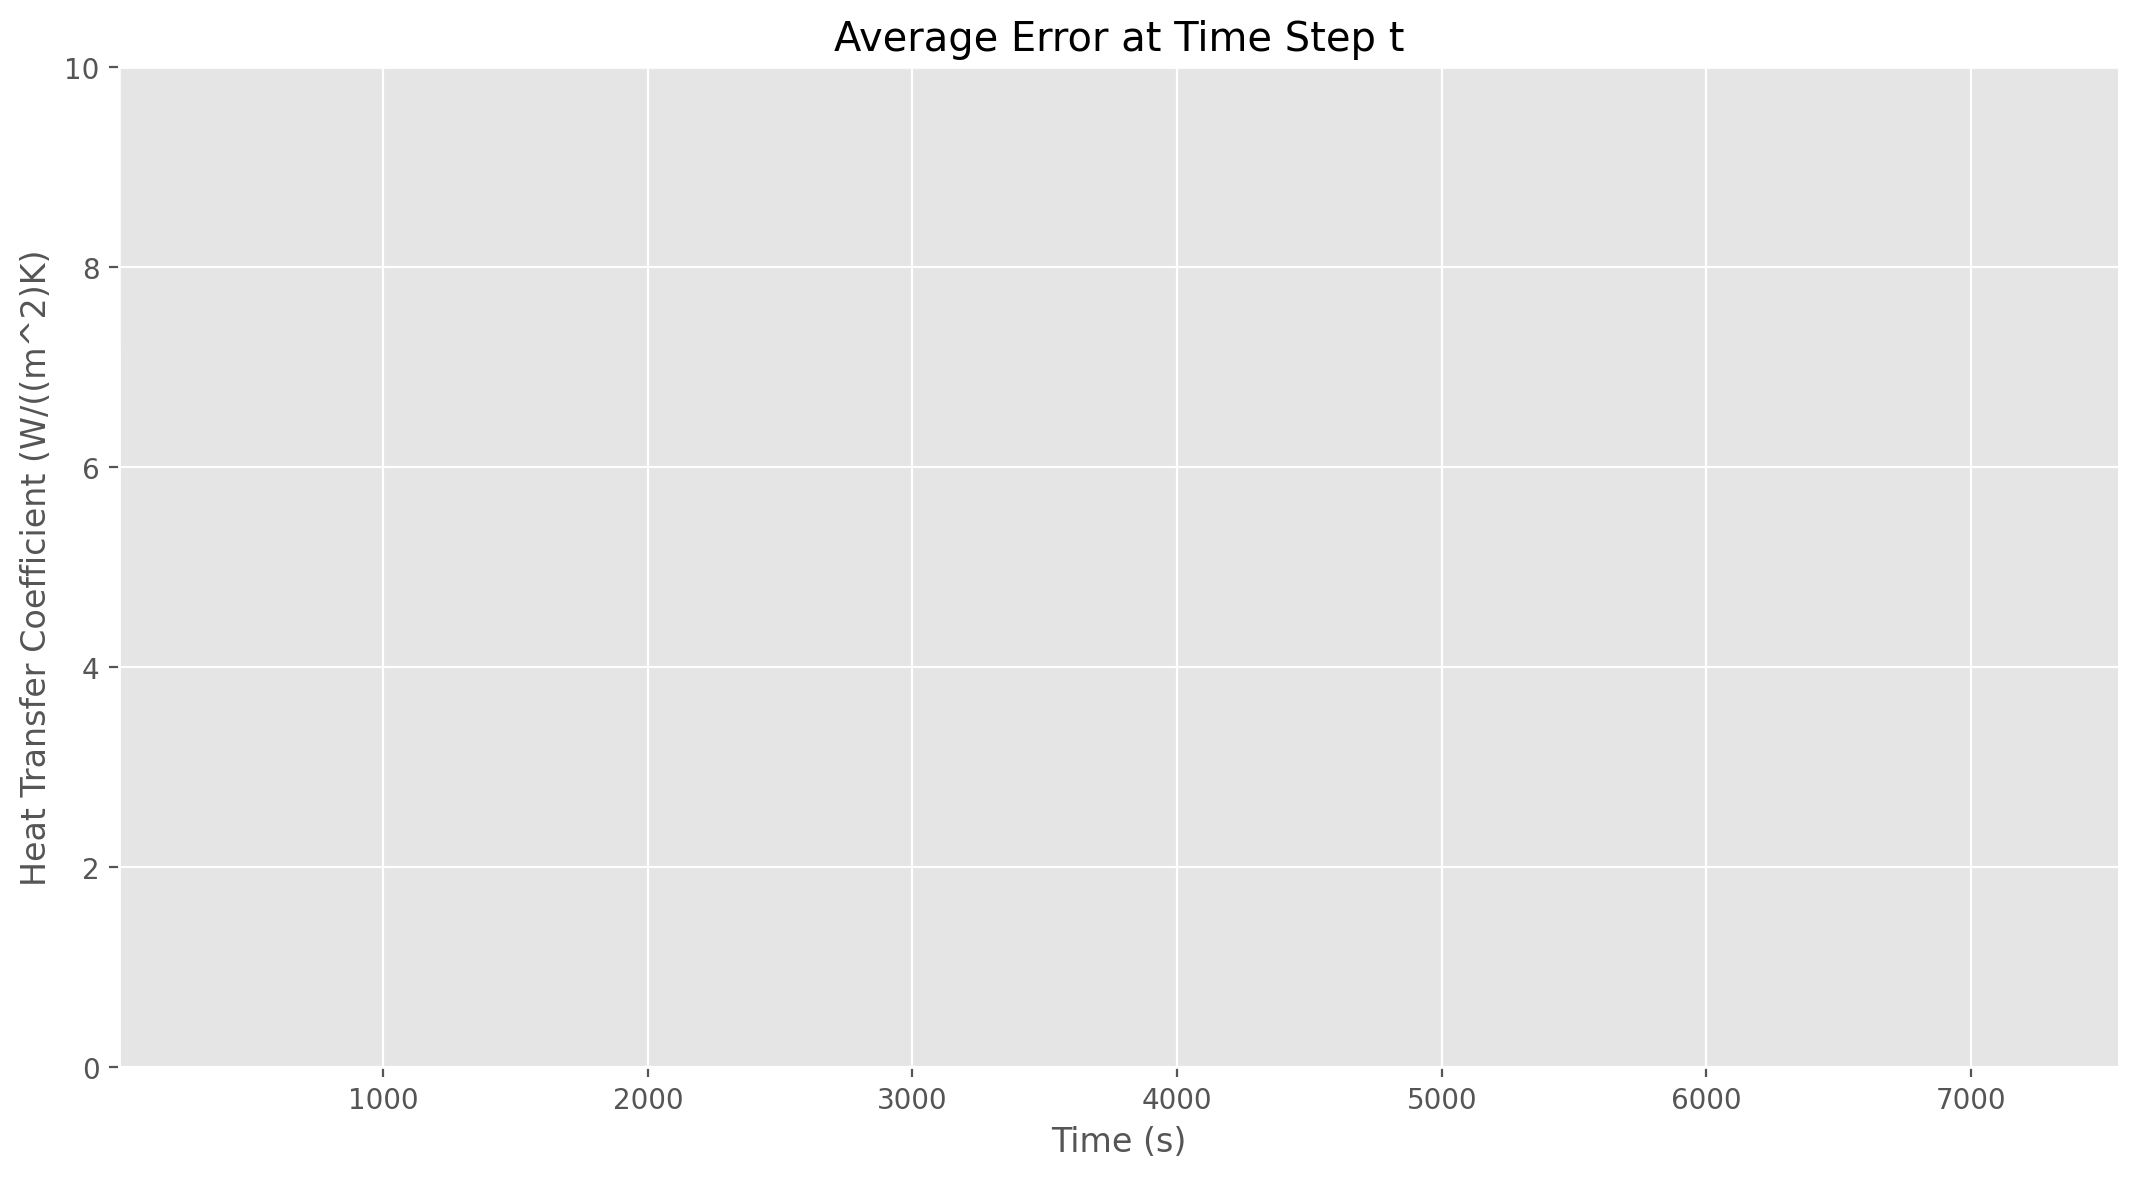

In [39]:
avg_error = plot_average_error(test_df, target=target)

<AxesSubplot:>

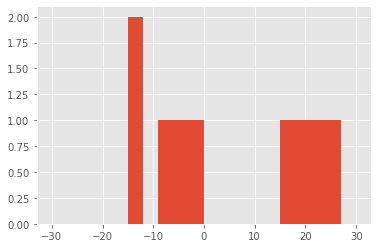

In [40]:
(test_df[target] - test_df[target+'_hat']).hist(bins=20, range=(-30, 30))

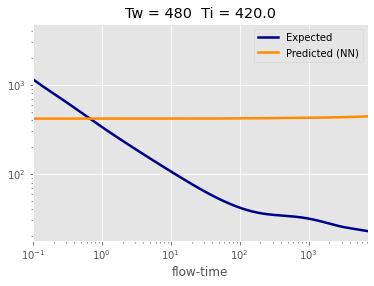

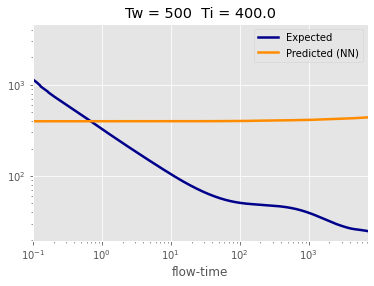

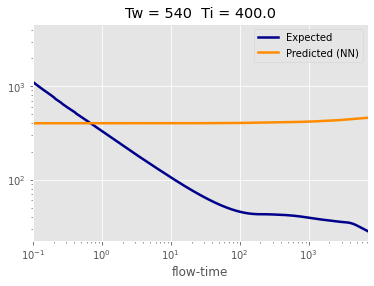

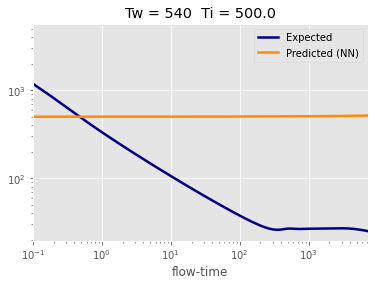

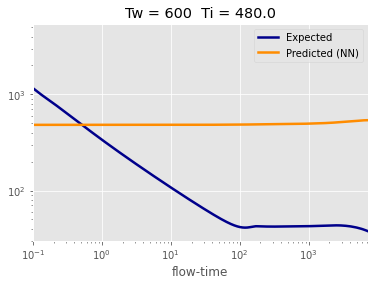

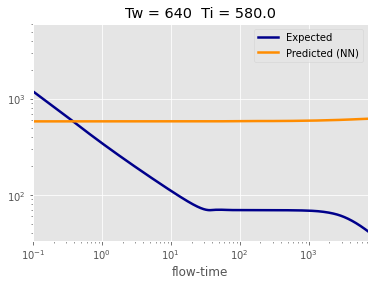

In [41]:
plot_test_results(test_df, model_type, target)

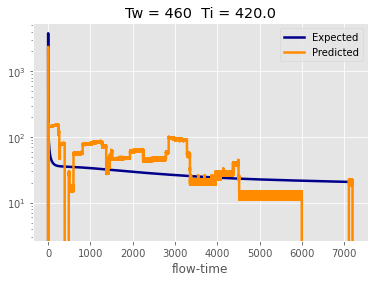

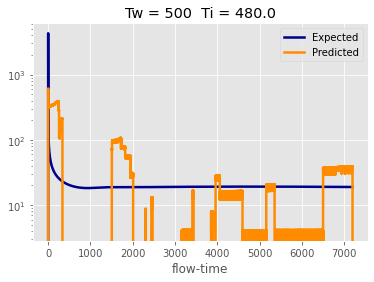

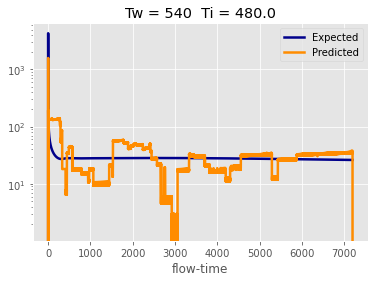

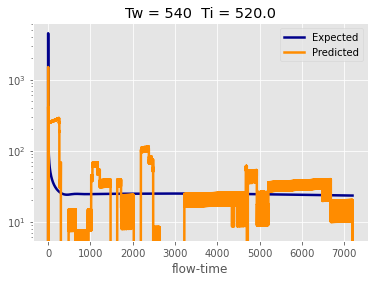

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/stesml-0+unknown-py3.9.egg/stesml/postprocessing_tools.py:53: RuntimeWarning: invalid value encountered in true_divide


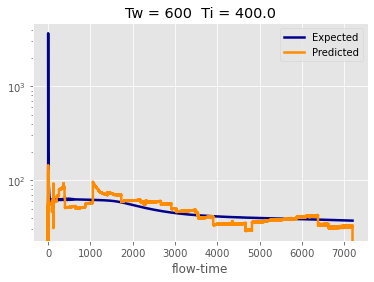

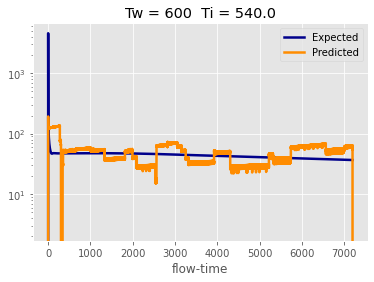

In [28]:
if target == 'Tavg':
    rmse, r2 = get_h_from_T_results(test_df, plot=True)
else:
    rmse, r2 = get_T_from_h_results(test_df, plot=True)

In [18]:
print(rmse)

3.0147395277285676


In [19]:
print(r2)

0.9951793649031446
